<a href="https://colab.research.google.com/github/SohamX05/Trader-Behaviour-Insights/blob/main/trader_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- PART A: DATA PREPARATION ---
Trader Data Shape: (211224, 16)
Trader Missing Values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment Data Shape: (2644, 4)
Sentiment Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Data preparation complete. Merged shape: (2340, 13)

--- PART B: ANALYSIS & SEGMENTATION ---

1. Overall Performance by Sentiment:
                   daily_PnL  win_rate
sentiment_group                       
Fear             5185.146443  0.842294
Greed            4144.208334  0.856307
Neutral          3438.618818  0.835721

2. Trader Behavior by Sentiment:
                 num_trades  avg_t

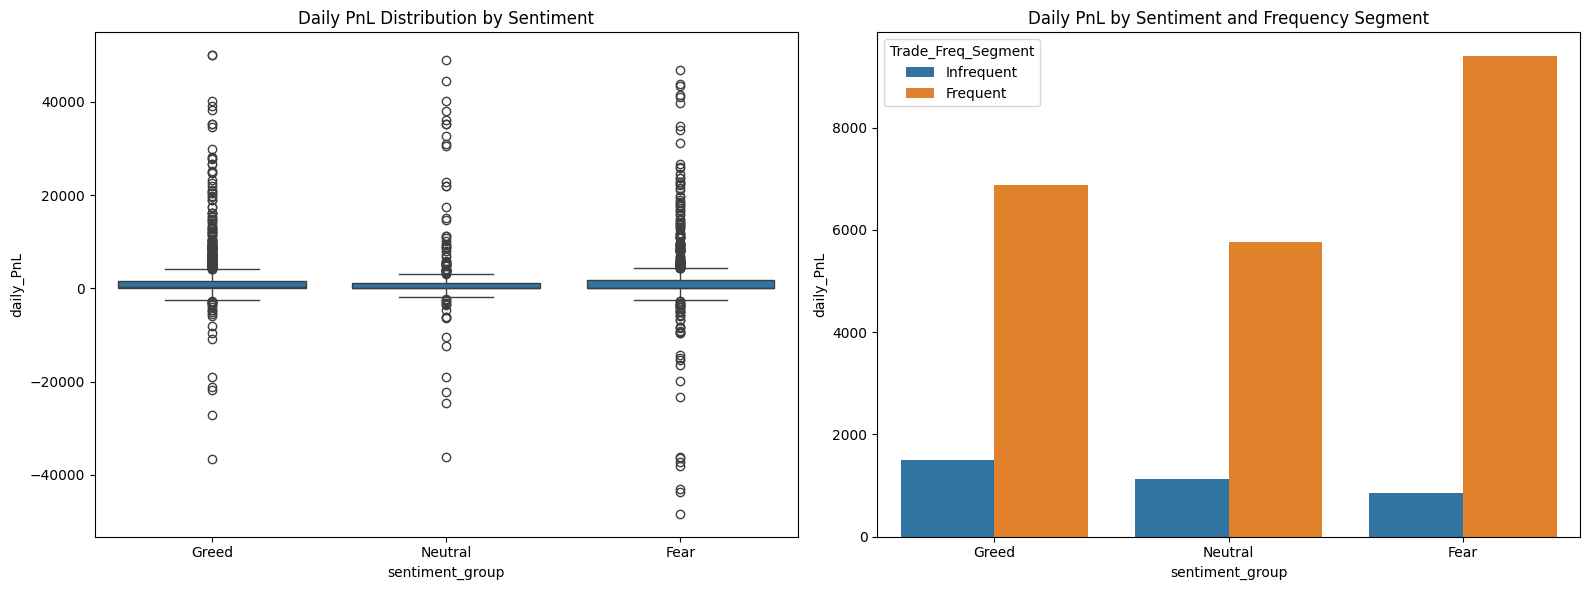


--- BONUS: MACHINE LEARNING ---

1. Clustering Traders into Archetypes...
Cluster Characteristics:
          total_trades  avg_trade_size  overall_win_rate  overall_long_ratio
Cluster                                                                    
0         3266.428571    15234.375129          0.902711            0.554470
1        17304.375000     2156.521460          0.870266            0.514576
2         2705.300000     5146.634481          0.724724            0.349860

2. Predicting Next-Day Profitability...
              precision    recall  f1-score   support

           0       0.30      0.06      0.10        97
           1       0.71      0.94      0.81       236

    accuracy                           0.68       333
   macro avg       0.50      0.50      0.46       333
weighted avg       0.59      0.68      0.60       333


Feature Importances:
               Feature  Importance
3            win_rate    0.244141
1  avg_trade_size_usd    0.214401
0          num_trades    0

In [3]:
# ==========================================
# Primetrade.ai - Data Science Intern Assignment
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# PART A: Data Preparation (Must-Have)
# ==========================================
print("--- PART A: DATA PREPARATION ---")

# 1. Load Datasets
trader_df = pd.read_csv('historical_data.zip')
sentiment_df = pd.read_csv('fear_greed_index.csv')

# Document Initial State
print(f"Trader Data Shape: {trader_df.shape}")
print(f"Trader Missing Values:\n{trader_df.isnull().sum()}\n")
print(f"Sentiment Data Shape: {sentiment_df.shape}")
print(f"Sentiment Missing Values:\n{sentiment_df.isnull().sum()}\n")

# 2. Convert timestamps and align datasets
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['Date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.date

# 3. Create Key Metrics (Daily per Account)
trader_df['is_long'] = trader_df['Side'].str.upper() == 'BUY'
trader_df['is_win'] = trader_df['Closed PnL'] > 0
trader_df['is_closed'] = trader_df['Closed PnL'] != 0

daily_trader = trader_df.groupby(['Date', 'Account']).apply(lambda x: pd.Series({
    'daily_PnL': x['Closed PnL'].sum(),
    'num_trades': len(x),
    'avg_trade_size_usd': x['Size USD'].mean(),
    'num_longs': x['is_long'].sum(),
    'wins': x['is_win'].sum(),
    'closed_trades': x['is_closed'].sum()
})).reset_index()

# Derive metrics safely (handling divide by zero)
daily_trader['win_rate'] = np.where(daily_trader['closed_trades'] > 0,
                                    daily_trader['wins'] / daily_trader['closed_trades'],
                                    np.nan)
daily_trader['long_ratio'] = daily_trader['num_longs'] / daily_trader['num_trades']

# 4. Merge Datasets
merged_df = pd.merge(daily_trader, sentiment_df[['Date', 'classification', 'value']], on='Date', how='inner')

# Simplify classifications for easier comparison
merged_df['sentiment_group'] = merged_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})

print("Data preparation complete. Merged shape:", merged_df.shape)


# ==========================================
# PART B: Analysis & Segmentation (Must-Have)
# ==========================================
print("\n--- PART B: ANALYSIS & SEGMENTATION ---")

# Q1: Performance Differences (Fear vs Greed)
print("\n1. Overall Performance by Sentiment:")
perf_summary = merged_df.groupby('sentiment_group')[['daily_PnL', 'win_rate']].mean()
print(perf_summary)

# Q2: Behavior Changes
print("\n2. Trader Behavior by Sentiment:")
behav_summary = merged_df.groupby('sentiment_group')[['num_trades', 'avg_trade_size_usd', 'long_ratio']].mean()
print(behav_summary)

# Q3: Segmentation (Frequent vs Infrequent Traders)
median_trades = merged_df['num_trades'].median()
merged_df['Trade_Freq_Segment'] = np.where(merged_df['num_trades'] > median_trades, 'Frequent', 'Infrequent')

print("\n3. Segment Analysis (Trade Frequency):")
segment_summary = merged_df.groupby(['Trade_Freq_Segment', 'sentiment_group'])[['daily_PnL', 'win_rate', 'avg_trade_size_usd']].mean()
print(segment_summary)

# Visualizations
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Daily PnL Distribution by Sentiment (Truncated for scale)
sns.boxplot(data=merged_df[merged_df['daily_PnL'].abs() < 50000], x='sentiment_group', y='daily_PnL', ax=ax[0])
ax[0].set_title('Daily PnL Distribution by Sentiment')

# Plot 2: PnL by Sentiment & Frequency Segment
sns.barplot(data=merged_df, x='sentiment_group', y='daily_PnL', hue='Trade_Freq_Segment', errorbar=None, ax=ax[1])
ax[1].set_title('Daily PnL by Sentiment and Frequency Segment')
plt.tight_layout()
plt.show()


# ==========================================
# BONUS: Clustering & Predictive Modeling
# ==========================================
print("\n--- BONUS: MACHINE LEARNING ---")
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1. Behavioral Archetypes (K-Means Clustering)
print("\n1. Clustering Traders into Archetypes...")
trader_profile = merged_df.groupby('Account').agg(
    total_trades=('num_trades', 'sum'),
    avg_trade_size=('avg_trade_size_usd', 'mean'),
    overall_win_rate=('win_rate', 'mean'),
    overall_long_ratio=('long_ratio', 'mean')
).dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(trader_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
trader_profile['Cluster'] = kmeans.fit_predict(scaled_features)
print("Cluster Characteristics:\n", trader_profile.groupby('Cluster').mean())

# 2. Predictive Model (Next-Day Profitability)
print("\n2. Predicting Next-Day Profitability...")
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values(by=['Account', 'Date'])

# Create target variable
merged_df['next_day_pnl'] = merged_df.groupby('Account')['daily_PnL'].shift(-1)
model_df = merged_df.dropna(subset=['next_day_pnl', 'win_rate']).copy()
model_df['next_day_profitable'] = (model_df['next_day_pnl'] > 0).astype(int)

features = ['num_trades', 'avg_trade_size_usd', 'long_ratio', 'win_rate', 'value']
X = model_df[features]
y = model_df['next_day_profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

importance = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)
print("\nFeature Importances:\n", importance)

# Save data for Streamlit Dashboard
merged_df.to_csv('merged_daily_trader_sentiment.csv', index=False)
trader_profile.to_csv('trader_clusters.csv', index=True)
print("\nData exported for Streamlit app (merged_daily_trader_sentiment.csv, trader_clusters.csv)")